In [64]:
%load_ext autoreload
%autoreload 2
import sys

# instead of creating a package using setup.py or building from a docker/singularity file,
# import the sister directory of src code to be called on in notebook.
# This keeps the notebook free from code to only hold visualizations and is easier to test
# It also helps keep the state of variables clean such that cells aren't run out of order with a mysterious state
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

# import sklearn.cluster.hierarchical as hclust
from sklearn import preprocessing
import seaborn as sns
from sklearn.metrics import silhouette_score

from src import most_recent_mesonet_data
from src import most_recent_mesonet_time
from src import landtype_describe
from src.plotting_scripts import landtype
import os
import pandas as pd
import cartopy.crs as crs
import cartopy.feature as cfeature
import time
import calendar

In [66]:
def plurality_plot(df):
    projPC = crs.PlateCarree()
    latN = df["lat"].max() + 1
    latS = df["lat"].min() - 1
    lonW = df["lon"].max() + 1
    lonE = df["lon"].min() - 1
    cLat = (latN + latS) / 2
    cLon = (lonW + lonE) / 2
    projLcc = crs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

    fig, ax = plt.subplots(
        figsize=(12, 9), subplot_kw={"projection": crs.PlateCarree()}, dpi=400
    )
    ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle="--")
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.STATES)
    ax.xticklabels_top = False
    ax.ylabels_right = False
    ax.gridlines(
        crs=crs.PlateCarree(),
        draw_labels=True,
        linewidth=2,
        color="black",
        alpha=0.5,
        linestyle="--",
    )
    ax.scatter(
        x=df["lon"],
        y=df["lat"],
        c=df["color"],
        s=40,
        marker="o",
        edgecolor="black",
        transform=crs.PlateCarree(),
    )
    ax.set_title("Mesonet Site Groups", size=16)
    ax.set_xlabel("Longitude", size=14)
    ax.set_ylabel("Latitude", size=14)
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
    ax.grid()

In [67]:
met_df = pd.read_csv("/home/aevans/nwp_bias/src/landtype/data/ny_met_clusters.csv")

In [68]:
geo_df = pd.read_csv("/home/aevans/nwp_bias/src/landtype/data/ny_geo_clusters.csv")

In [69]:
nysm_df = pd.read_csv("/home/aevans/nwp_bias/src/landtype/data/nysm.csv")

In [70]:
met_df.head()

,Unnamed: 0.1,Unnamed: 0,station,latitude,longitude,Cluster,color
0,0,0,ADDI,42.040359,-77.237259,0,black
1,1,1,ANDE,42.182270,-74.801392,0,black
2,2,2,BATA,43.019939,-78.135658,2,green
3,3,3,BEAC,41.528751,-73.945267,3,red
4,4,4,BELD,42.223221,-75.668518,0,black


In [71]:
geo_df.head()

,Unnamed: 0,station,Cluster,lon,lat,color
0,0,ADDI,1,-77.237259,42.040359,blue
1,1,ANDE,7,-74.801392,42.182270,gray
2,2,BATA,4,-78.135658,43.019939,pink
3,3,BEAC,6,-73.945267,41.528751,magenta
4,4,BELD,1,-75.668518,42.223221,blue


In [72]:
nysm_df.head()

,stid,number,name,lat [degrees],lon [degrees],elevation [m],county,nearest_city,state,distance_from_town [km],direction_from_town [degrees],climate_division,climate_division_name,wfo,commissioned,decommissioned
0,ADDI,107,Addison,42.04036,-77.23726,507.6140,Steuben,Addison,NY,6.9,S,1,Western Plateau,BGM,2016-08-10 18:15:00 UTC,NaN
1,ANDE,111,Andes,42.18227,-74.80139,518.2820,Delaware,Andes,NY,1.5,WSW,2,Eastern Plateau,BGM,2016-08-04 15:55:00 UTC,NaN
2,BATA,24,Batavia,43.01994,-78.13566,276.1200,Genesee,Batavia,NY,4.9,ENE,9,Great Lakes,BUF,2016-02-18 18:40:00 UTC,NaN
3,BEAC,76,Beacon,41.52875,-73.94527,90.1598,Dutchess,Beacon,NY,3.3,NE,5,Hudson Valley,ALY,2016-08-22 16:45:00 UTC,NaN
4,BELD,90,Belden,42.22322,-75.66852,470.3700,Broome,Belden,NY,2.2,NNE,2,Eastern Plateau,BGM,2015-11-30 20:20:00 UTC,NaN


In [73]:
lats = nysm_df["lat [degrees]"].tolist()
lons = nysm_df["lon [degrees]"].tolist()

In [74]:
value = nysm_df["climate_division"].iloc[0]

In [75]:
exam_df = nysm_df[nysm_df["climate_division"] == value]

In [76]:
blank_df = pd.DataFrame()
blank_df["station"] = nysm_df["stid"]
blank_df["Cluster"] = 0

In [77]:
blank_df1 = pd.DataFrame()
blank_df1["station"] = nysm_df["stid"]
blank_df1["Cluster"] = 0

In [78]:
j = 1
for n in np.arange(1, 11):
    exam_df1 = nysm_df[nysm_df["climate_division"] == n]
    ls1 = exam_df1["stid"].tolist()
    exam_df2 = geo_df[geo_df["station"].isin(ls1)]
    cluster_vals = exam_df2["Cluster"].unique()
    for value in cluster_vals:
        df = exam_df2[exam_df2["Cluster"] == value]
        station_ls = df["station"].tolist()
        for i, _ in enumerate(blank_df["station"]):
            if blank_df["station"].iloc[i] in station_ls:
                blank_df["Cluster"].iloc[i] = j
        j += 1

/tmp/tmp.XuU7WcWGAU/ipykernel_1617733/1684138850.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blank_df['Cluster'].iloc[i] = j


In [79]:
colors = [
    "black",
    "blue",
    "green",
    "red",
    "orange",
    "yellow",
    "white",
    "purple",
    "cyan",
    "plum",
    "coral",
    "pink",
    "gold",
    "lightgray",
    "sienna",
    "chocolate",
    "darkorange",
    "darkkhaki",
    "lawngreen",
    "palegreen",
    "lightcyan",
    "turquoise",
    "aqua",
    "steelblue",
    "slategray",
    "mediumblue",
    "navy",
    "blueviolet",
    "mediumorchid",
    "hotpink",
    "pink",
]


legend = [
    0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24,
    25,
    26,
    27,
    28,
    29,
    30,
]

colordict = {}

for x, _ in enumerate(colors):
    colordict.update({legend[x]: colors[x]})

blank_df["color"] = blank_df["Cluster"].map(colordict)

In [80]:
blank_df["lat"] = lats
blank_df["lon"] = lons

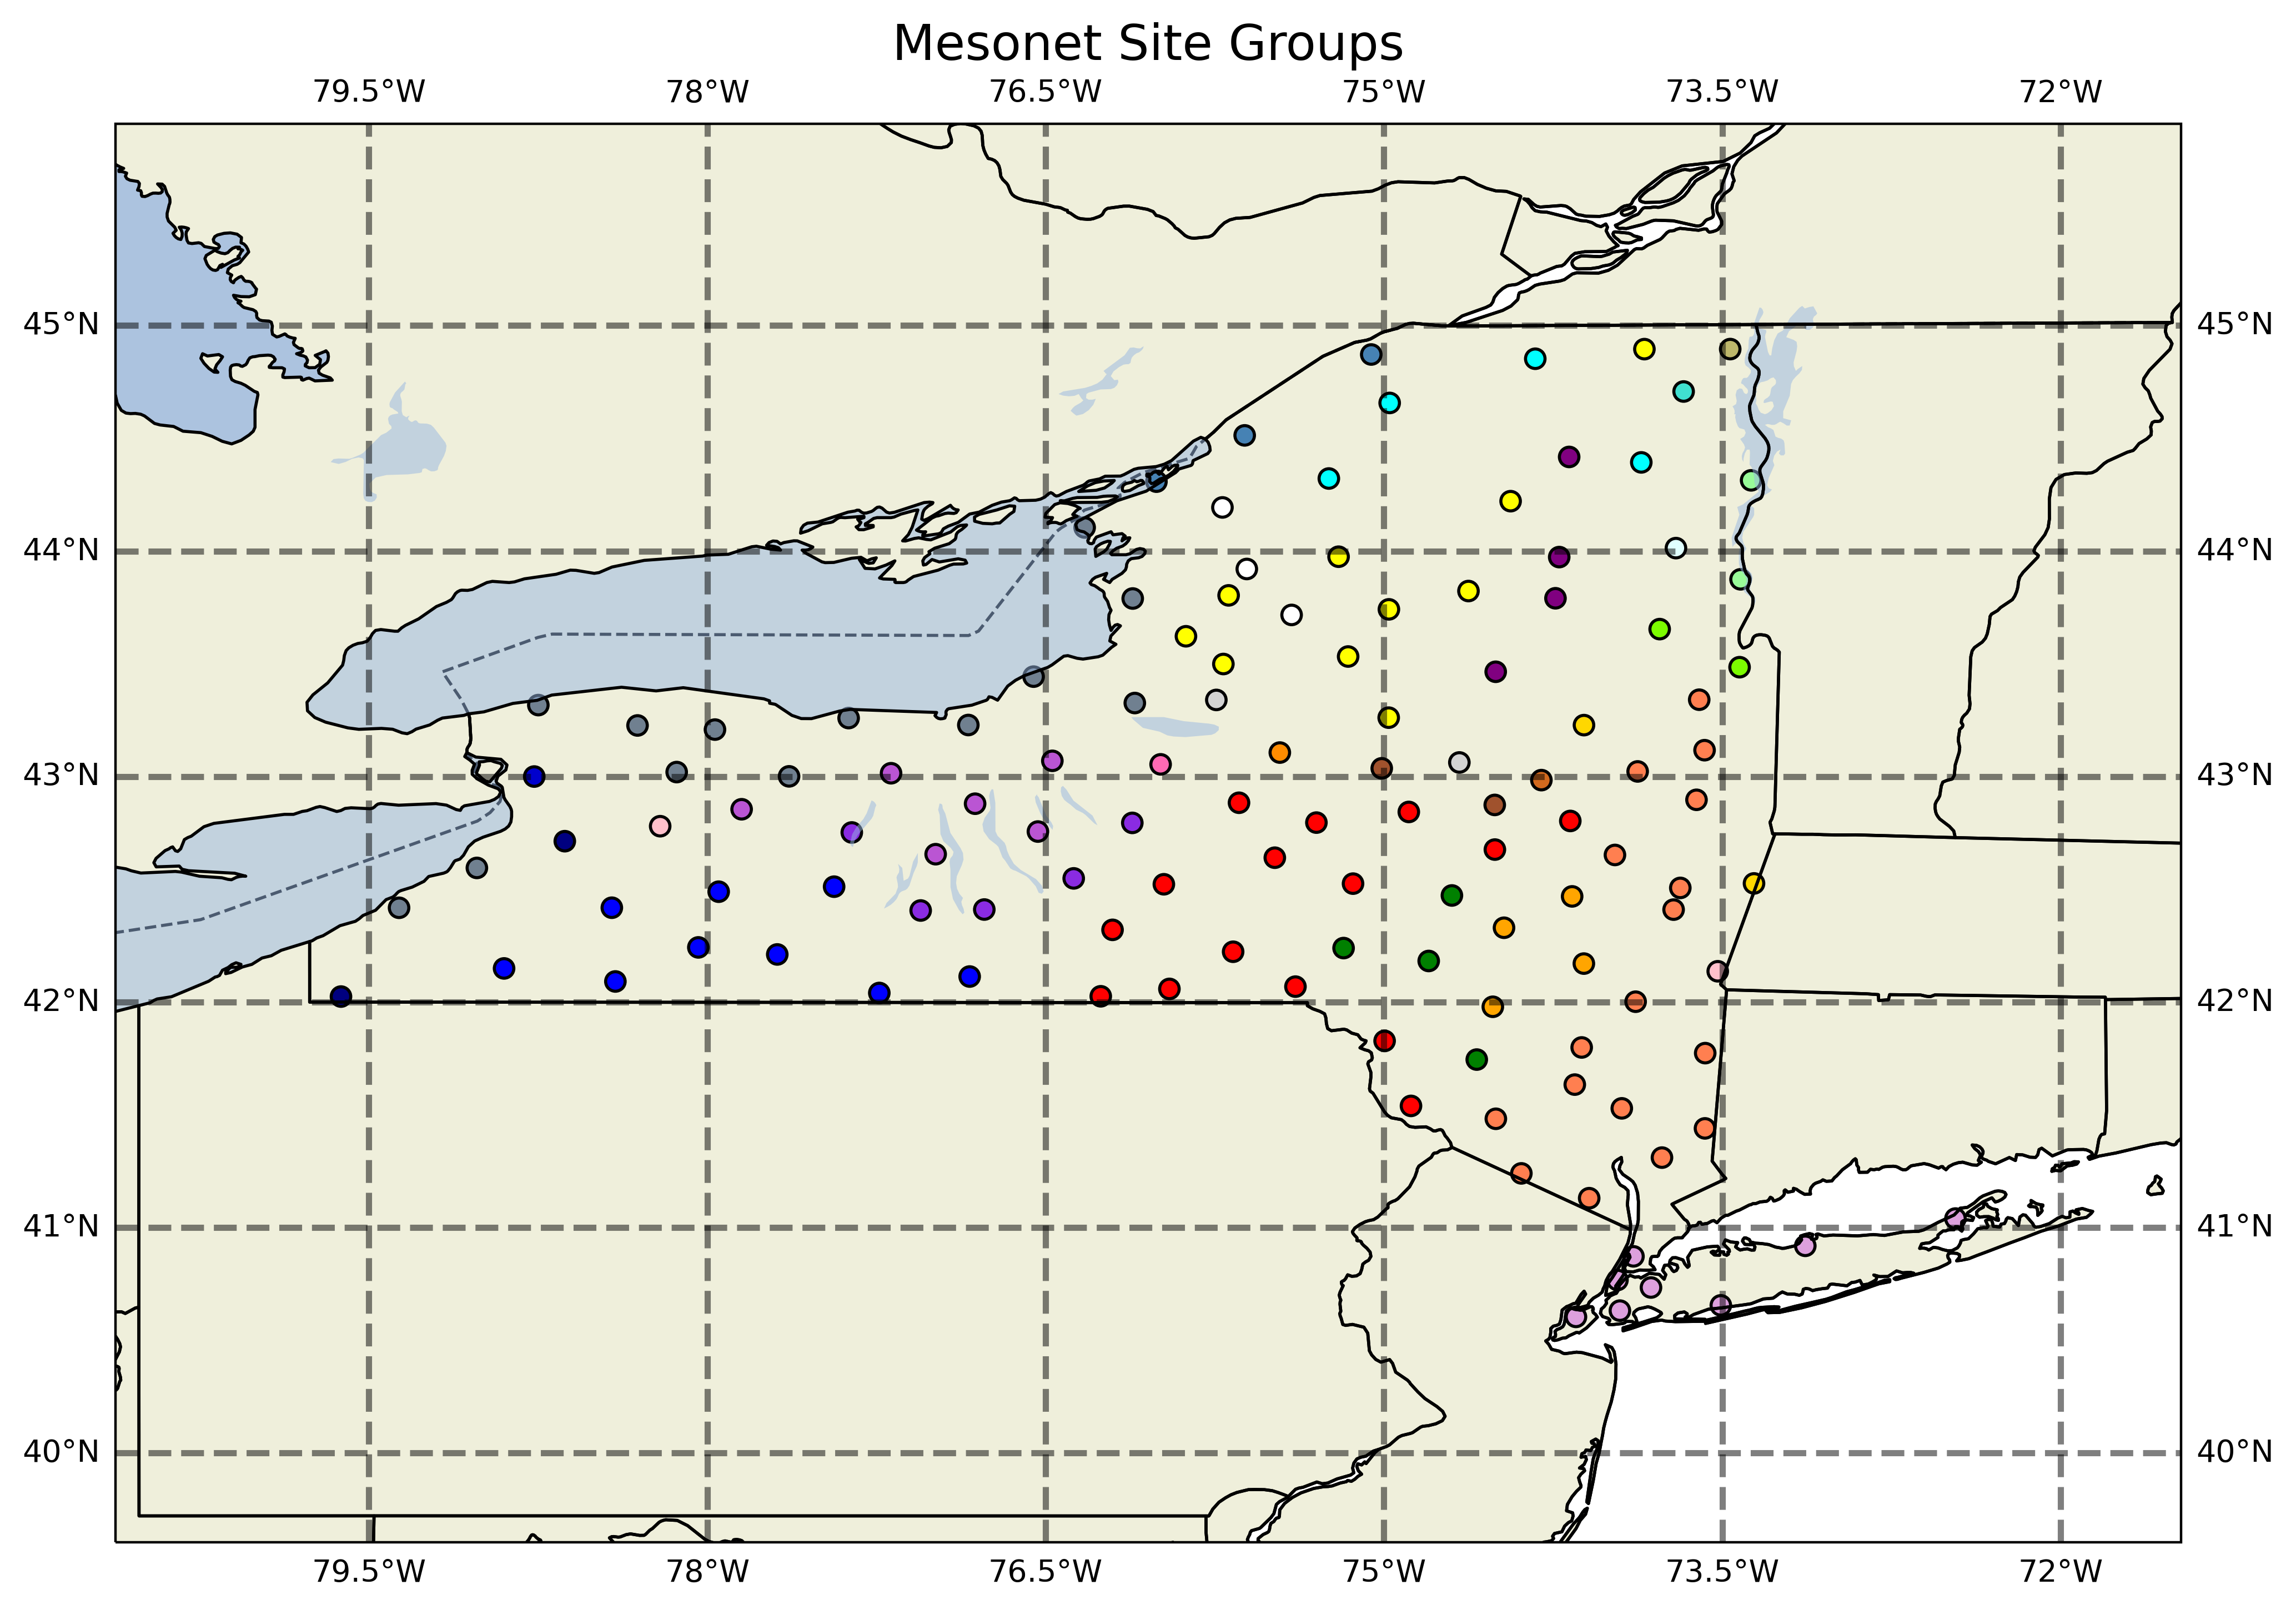

In [81]:
plurality_plot(blank_df)

In [82]:
j = 1
for n in np.arange(0, 31):
    exam_df1 = blank_df[blank_df["Cluster"] == n]
    ls1 = exam_df1["station"].tolist()
    exam_df2 = met_df[met_df["station"].isin(ls1)]
    cluster_vals = exam_df2["Cluster"].unique()
    for value in cluster_vals:
        df = exam_df2[exam_df2["Cluster"] == value]
        station_ls = df["station"].tolist()
        for i, _ in enumerate(blank_df1["station"]):
            if blank_df1["station"].iloc[i] in station_ls:
                blank_df1["Cluster"].iloc[i] = j
        j += 1

/tmp/tmp.XuU7WcWGAU/ipykernel_1617733/1925623730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blank_df1['Cluster'].iloc[i] = j


In [83]:
blank_df1["lat"] = lats
blank_df1["lon"] = lons

In [84]:
blank_df1

,station,Cluster,lat,lon
0,ADDI,1,42.040360,-77.237260
1,ANDE,3,42.182270,-74.801390
2,BATA,32,43.019940,-78.135660
3,BEAC,16,41.528750,-73.945270
4,BELD,4,42.223220,-75.668520
...,...,...,...,...
121,WFMB,14,44.393236,-73.858829
122,WGAT,8,43.532408,-75.158597
123,WHIT,26,43.485073,-73.423071
124,WOLC,32,43.228680,-76.842610


In [85]:
def clusters_plot(blank_df1):
    projPC = crs.PlateCarree()
    latN = blank_df1["lat"].max() + 1
    latS = blank_df1["lat"].min() - 1
    lonW = blank_df1["lon"].max() + 1
    lonE = blank_df1["lon"].min() - 1
    cLat = (latN + latS) / 2
    cLon = (lonW + lonE) / 2
    projLcc = crs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={"projection": crs.PlateCarree()})
    ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle="--")
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.STATES)
    ax.xticklabels_top = False
    ax.ylabels_right = False
    ax.gridlines(
        crs=crs.PlateCarree(),
        draw_labels=True,
        linewidth=2,
        color="black",
        alpha=0.5,
        linestyle="--",
    )
    ax.scatter(
        x=blank_df1["lon"],
        y=blank_df1["lat"],
        c=blank_df1["Cluster"],
        s=40,
        marker="o",
        edgecolor="black",
        transform=crs.PlateCarree(),
        cmap="rainbow",
    )
    ax.set_title("Mesonet Site Groups", size=16)
    ax.set_xlabel("Longitude", size=14)
    ax.set_ylabel("Latitude", size=14)
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
    ax.grid()

In [88]:
clusters = blank_df1["Cluster"].unique()

/tmp/tmp.XuU7WcWGAU/ipykernel_1617733/2263849472.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(


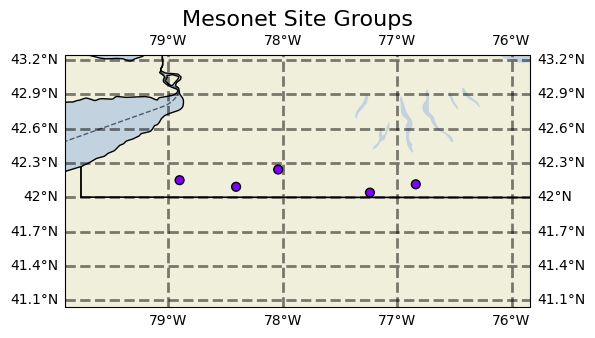

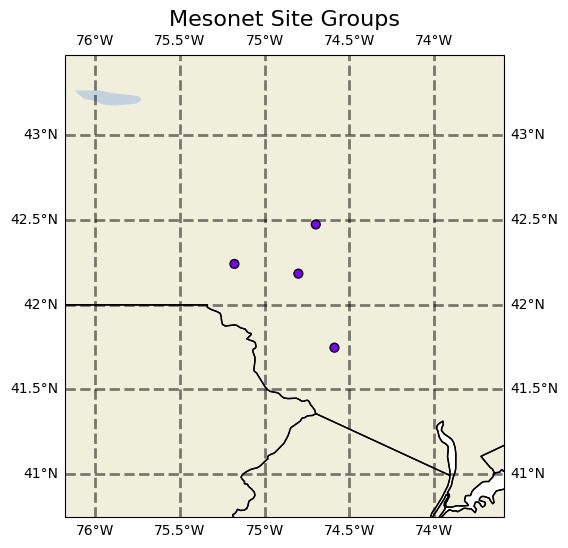

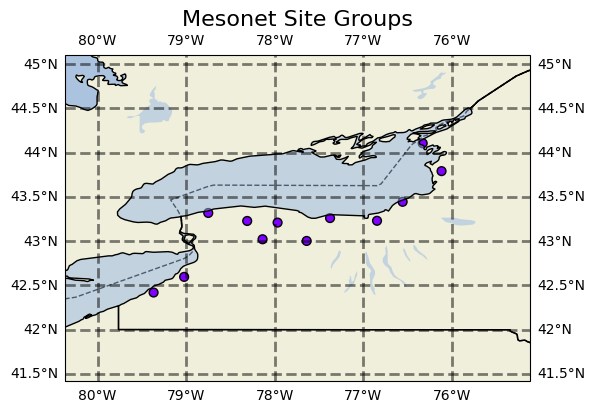

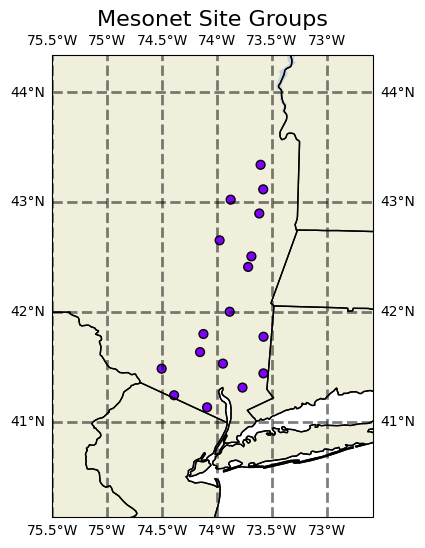

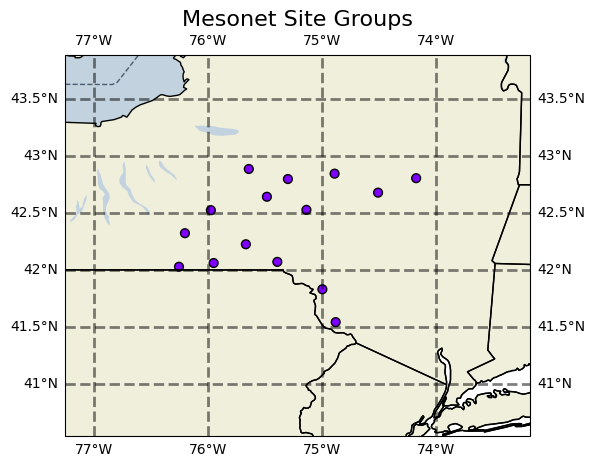

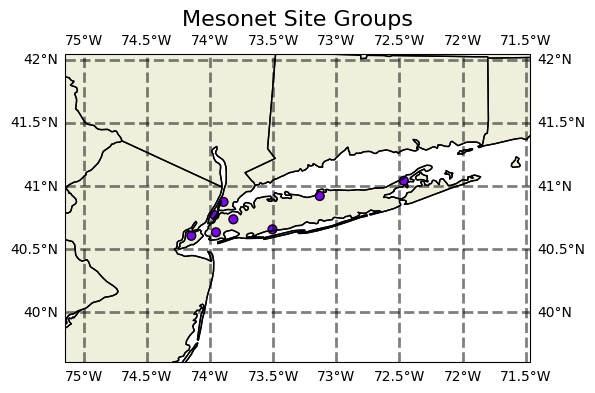

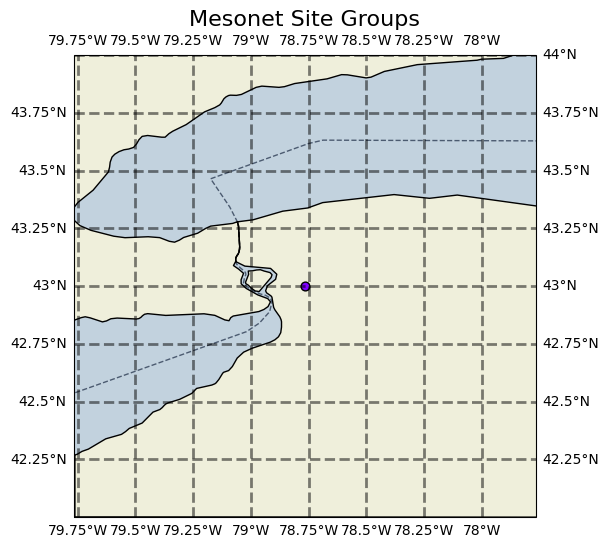

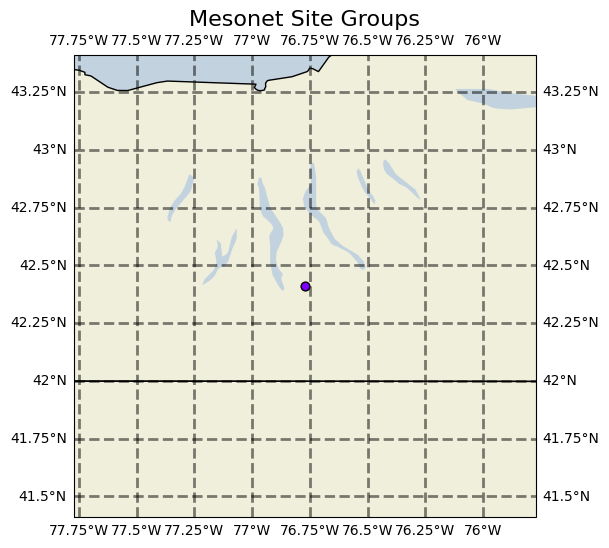

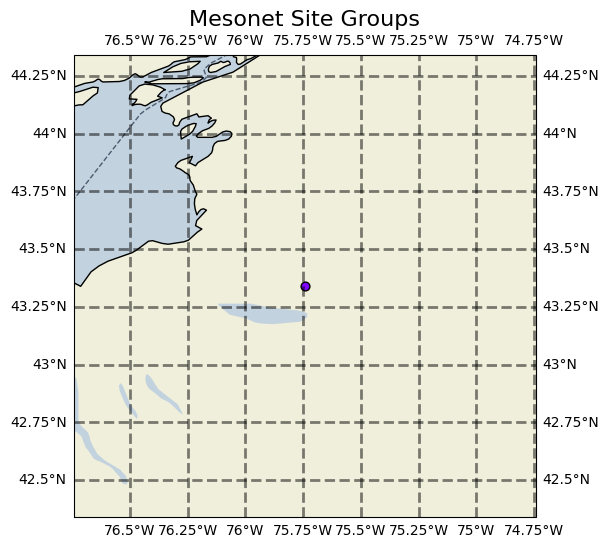

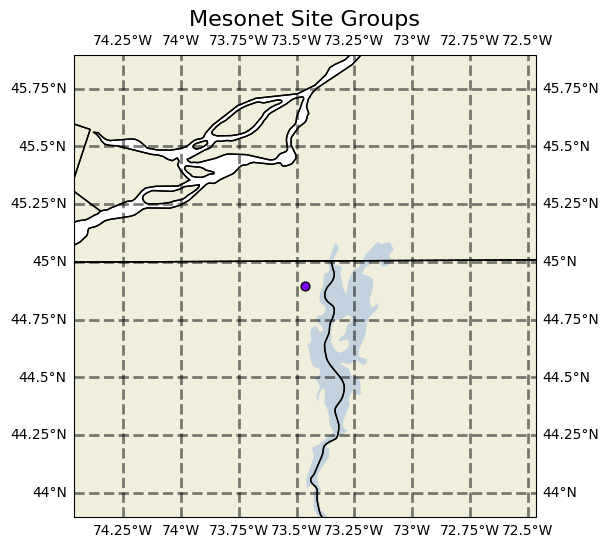

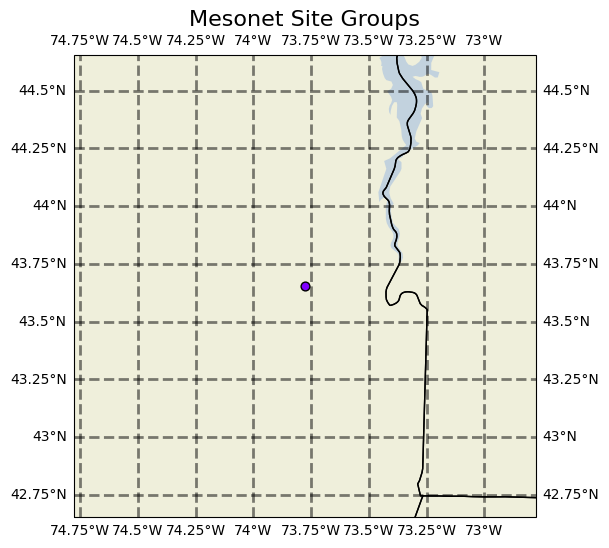

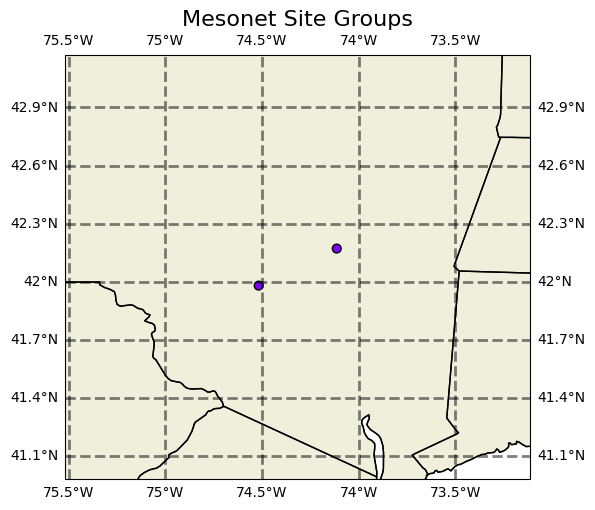

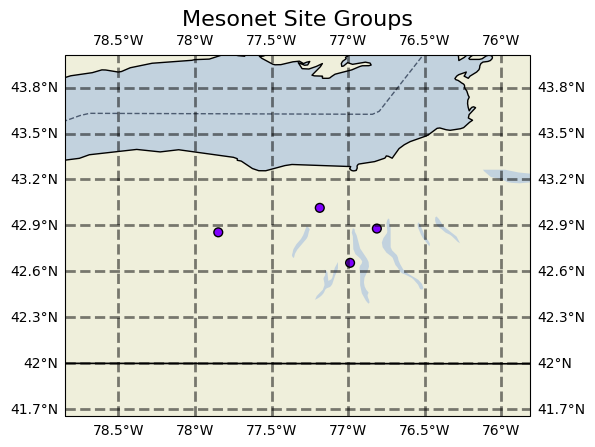

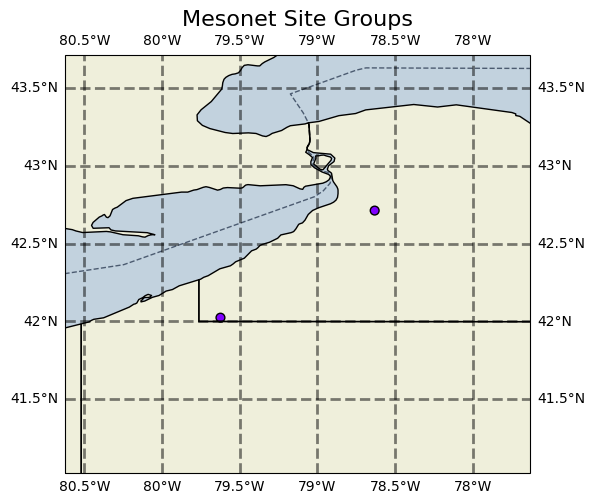

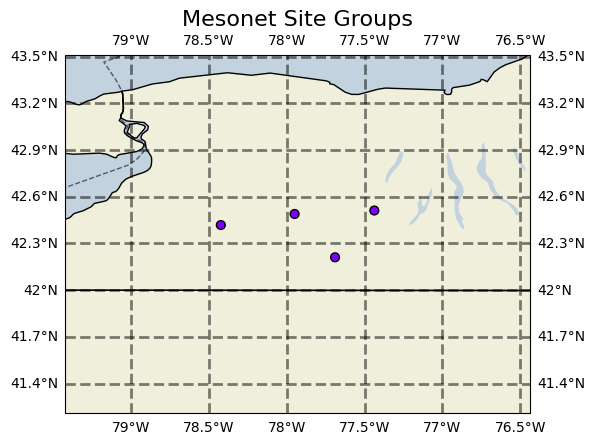

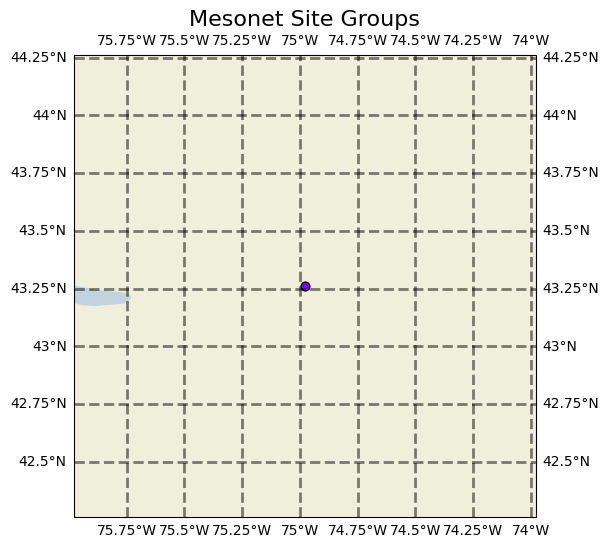

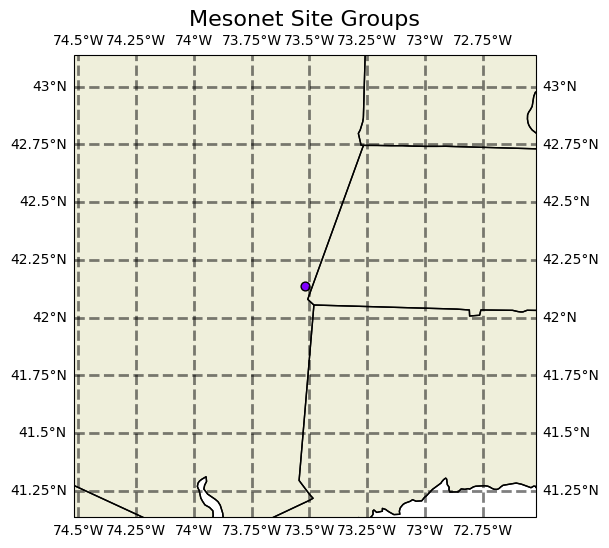

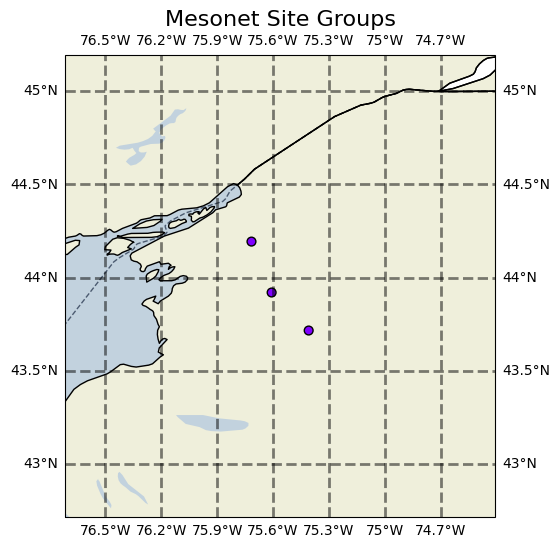

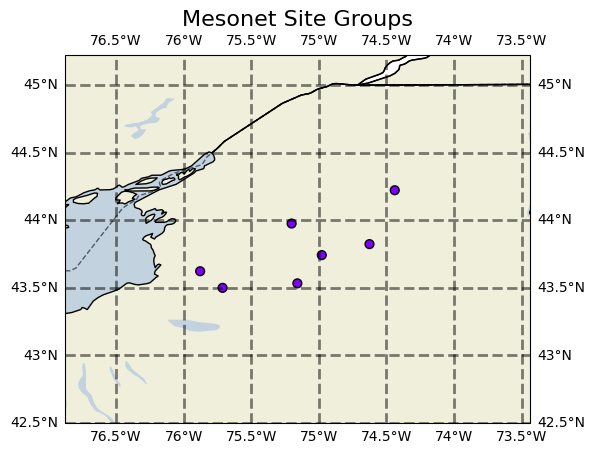

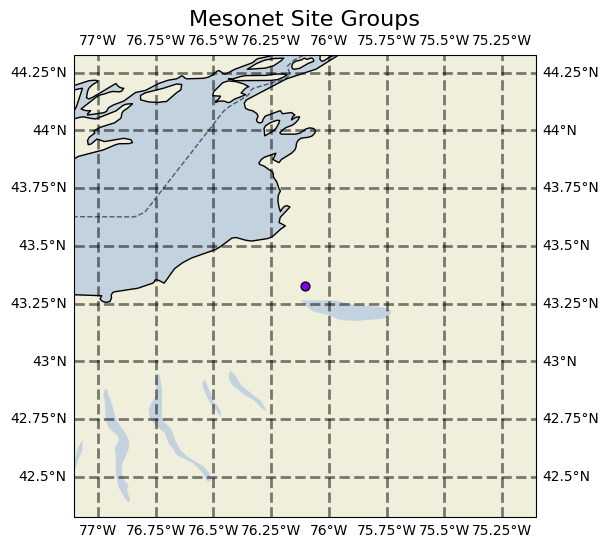

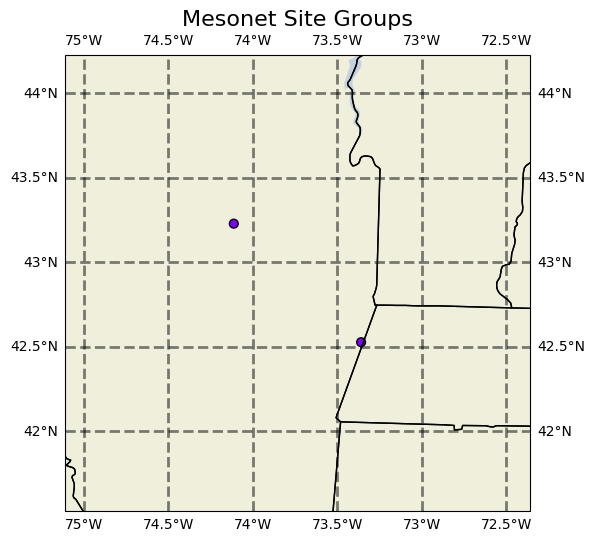

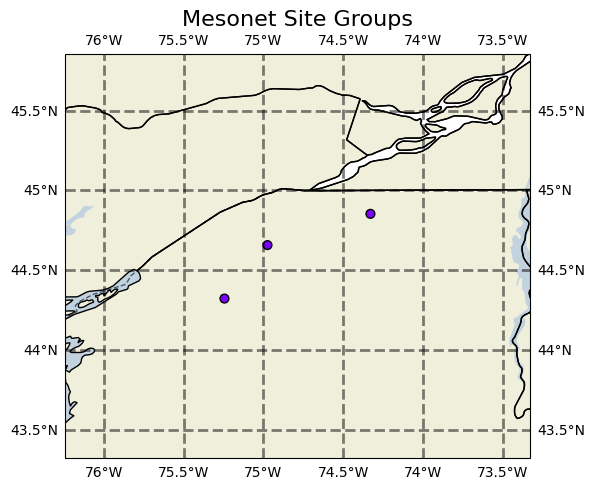

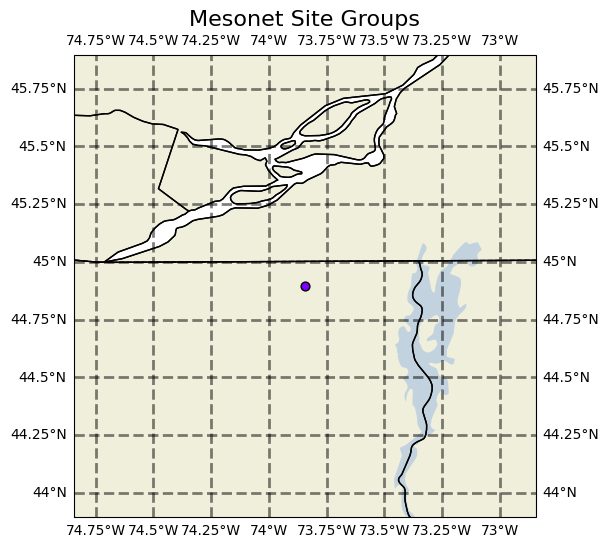

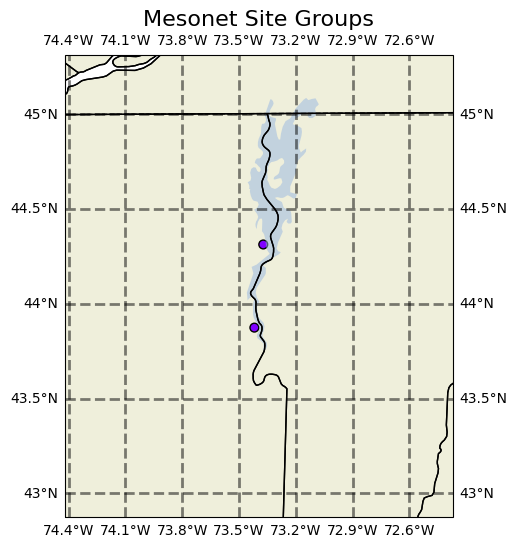

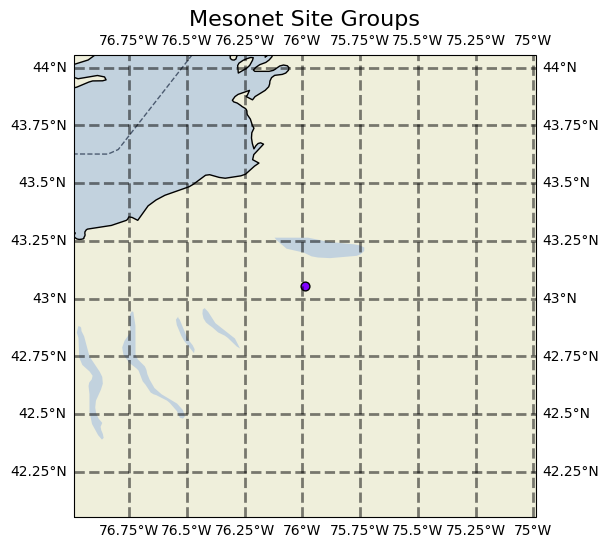

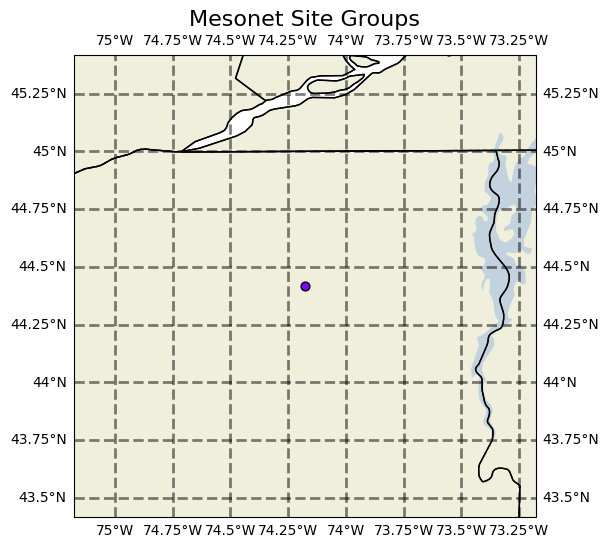

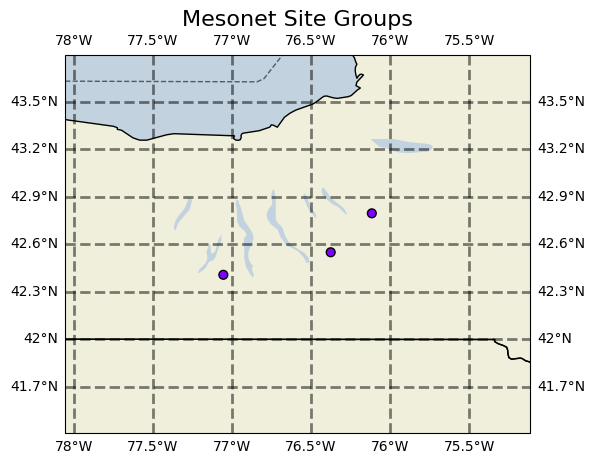

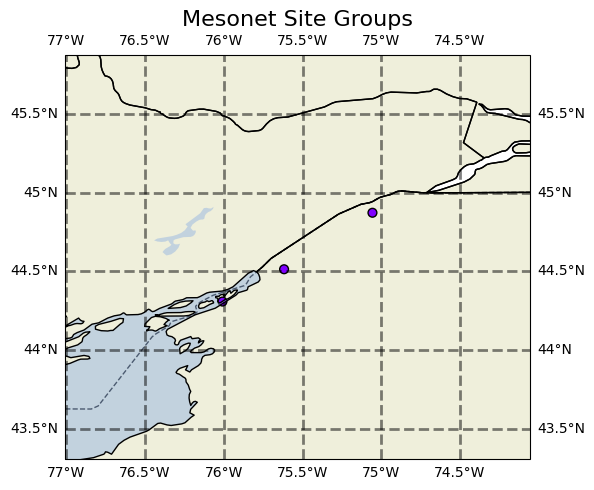

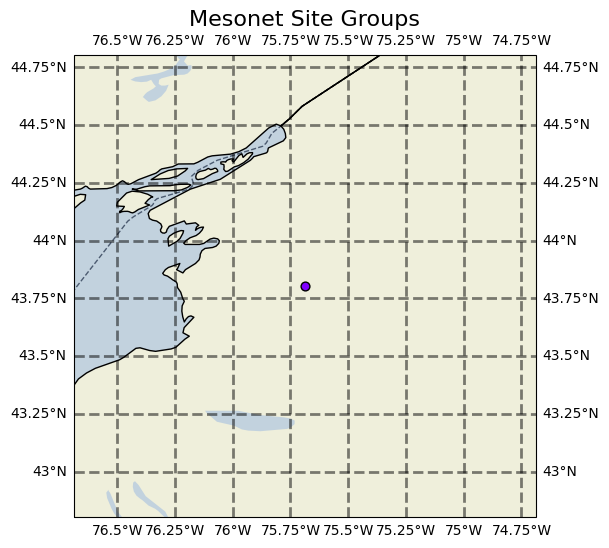

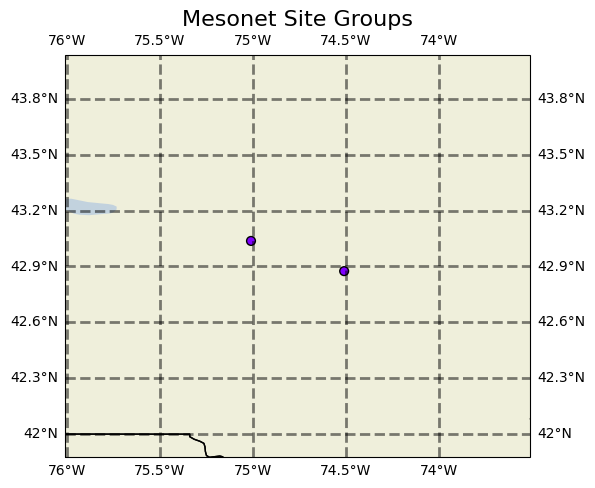

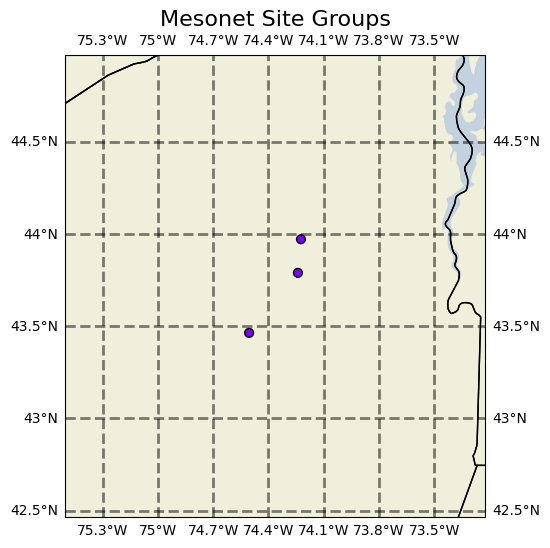

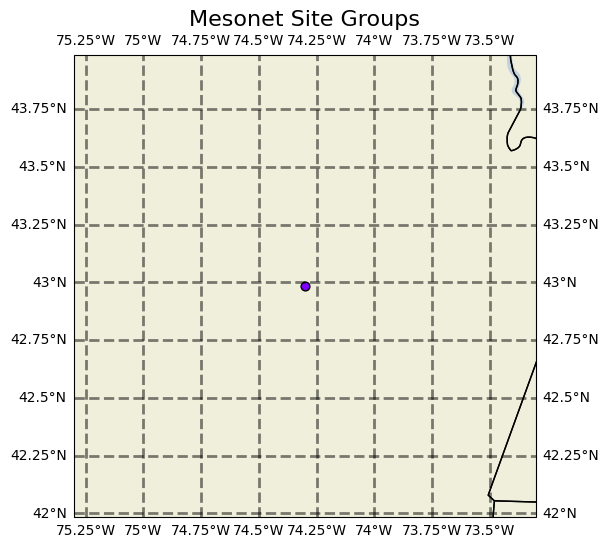

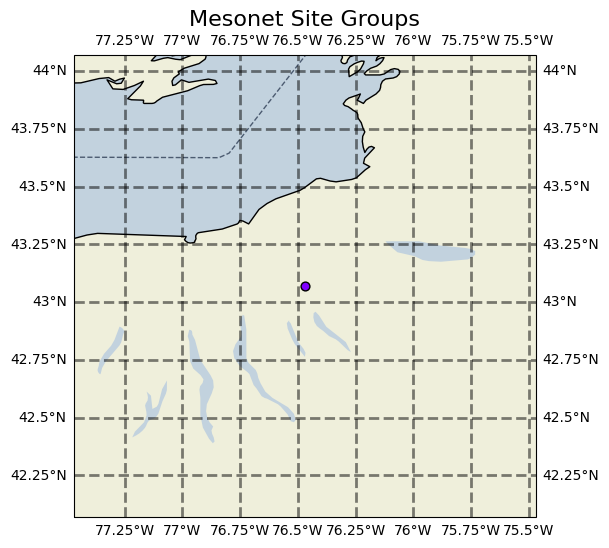

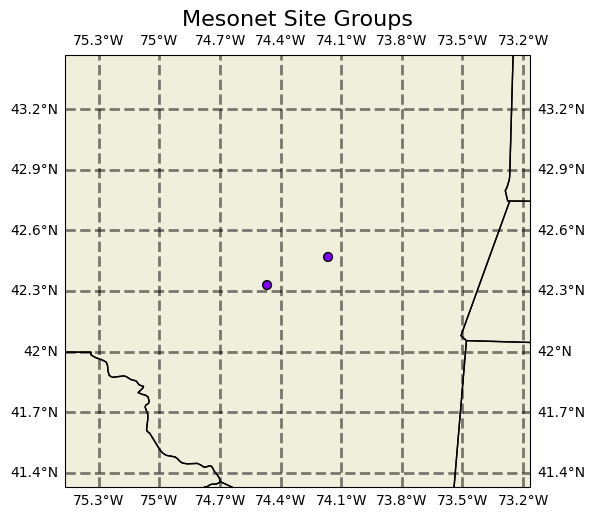

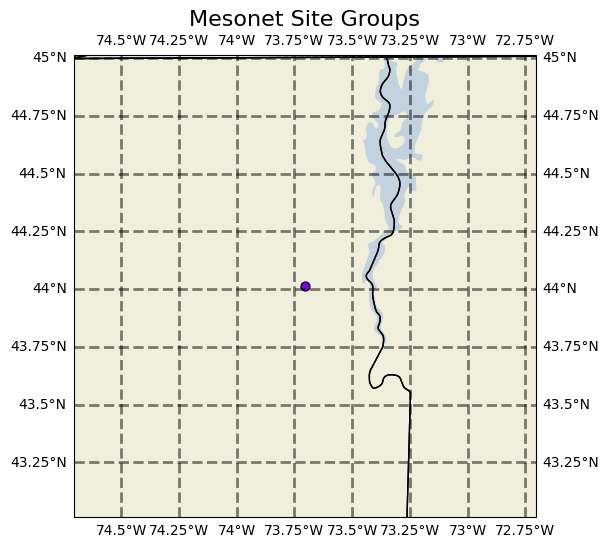

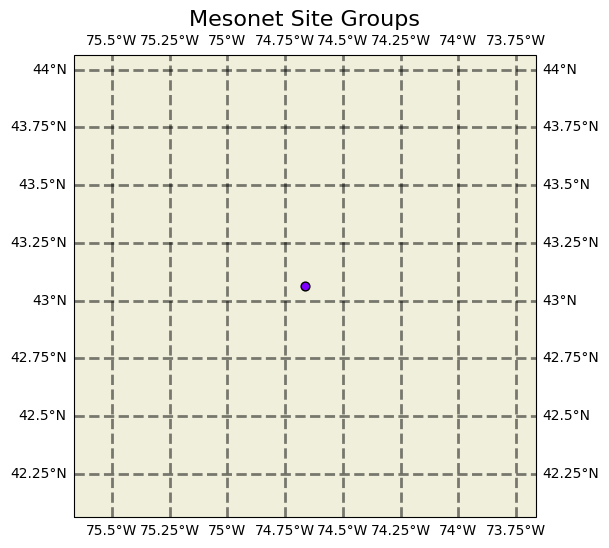

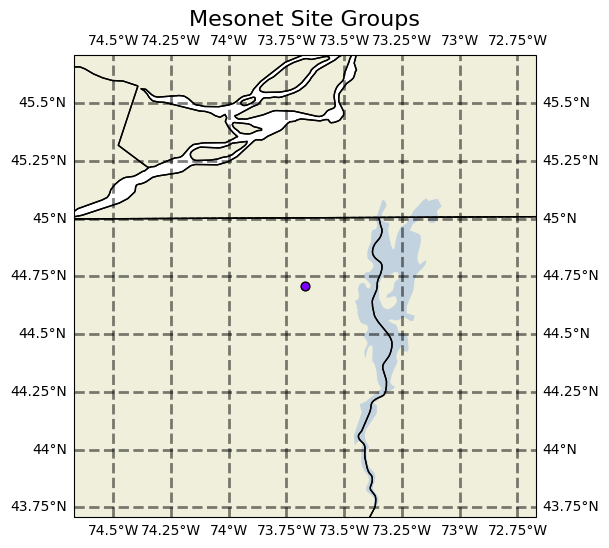

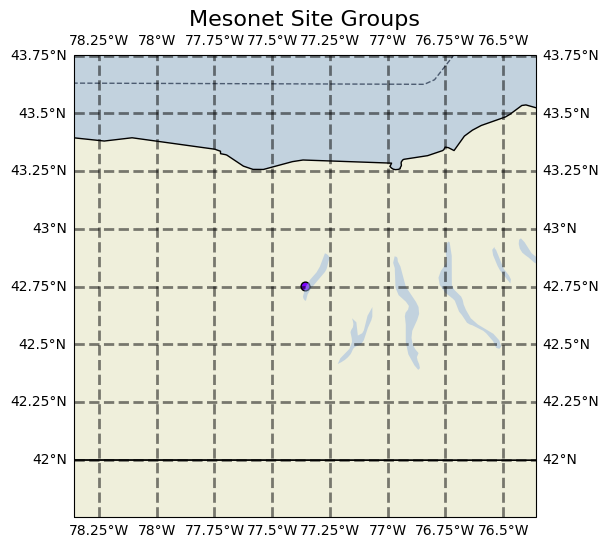

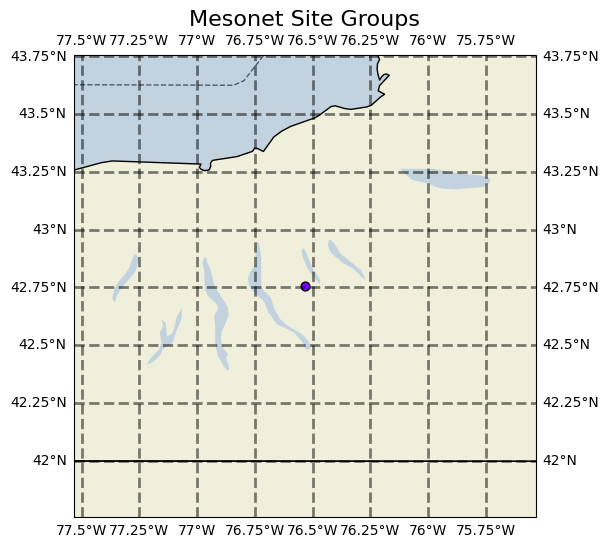

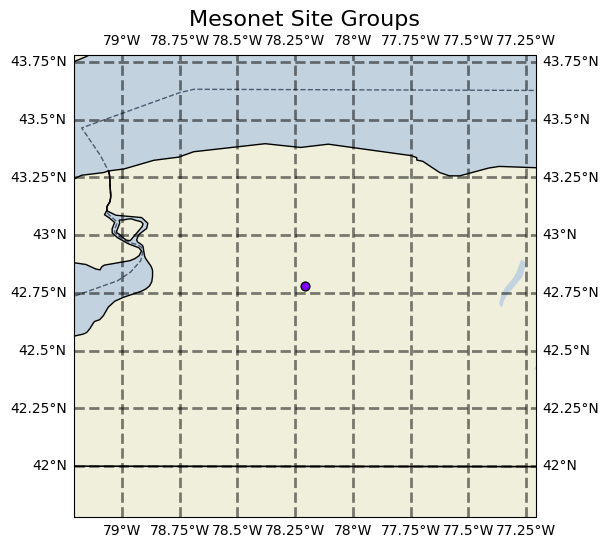

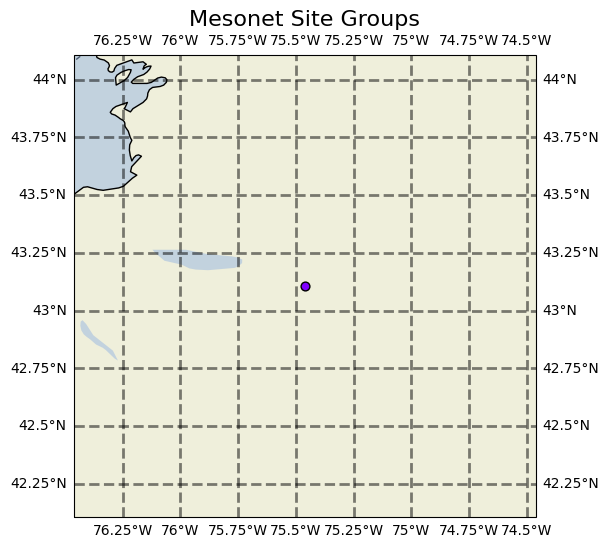

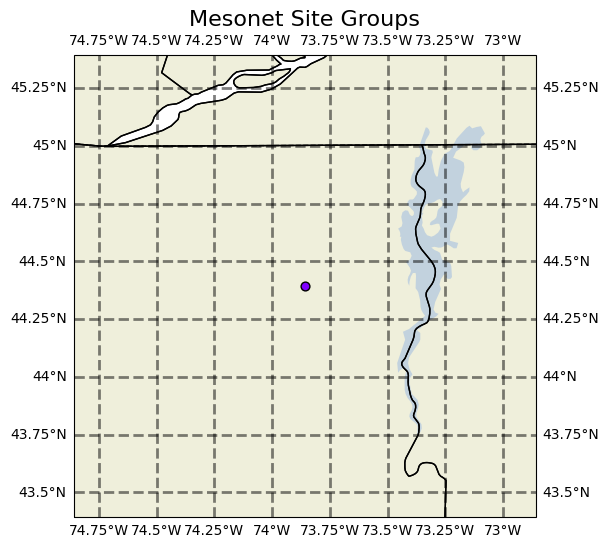

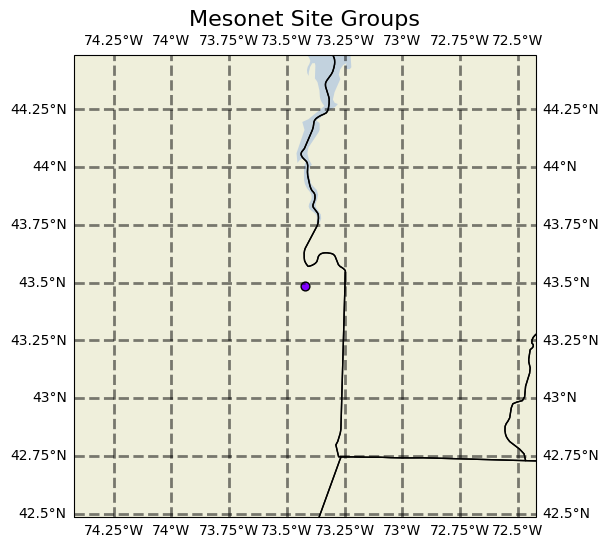

In [89]:
for cluster in clusters:
    the_df = blank_df1[blank_df1["Cluster"] == cluster]
    clusters_plot(the_df)